## Adquisición, Preprocesamiento y análisis de datos.

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
def load_data() -> pd.DataFrame:
  path = "/content/drive/MyDrive/FACULTAD/Introducción a la ciencia de datos/TP1/data_to_analyze.txt"
  df = pd.read_csv(path)
  df2 = df.loc[:,"yy":"time"].astype(str)
  df["datetime"] = pd.to_datetime(df2.agg("-".join,axis=1),format="%Y-%m-%d-%H:%M")
  df = df.drop(columns=["yy","mm","dd","time"])
  return df[["datetime","data"]]

In [ ]:
df = load_data()
print(df.head())

             datetime  data
0 2021-01-01 00:00:00   7.3
1 2021-01-01 00:10:00   7.5
2 2021-01-01 00:50:00   6.9
3 2021-01-01 01:00:00   6.4
4 2021-01-01 01:10:00   6.0


Columnas que posee el set de datos

In [ ]:
print(df.columns)

Index(['datetime', 'data'], dtype='object')


Tipo de dato y dominio de cada columna.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4391 entries, 0 to 4390
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  4391 non-null   datetime64[ns]
 1   data      3144 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 68.7 KB
None


Determinar: máximo valor, mínimo valor, media, mediana, moda, cantidad de
datos, desviación estándar.

In [ ]:
data = df["data"]
minimo,maximo,media,mediana,moda,cantidad,std = (data.min(),data.max(),data.mean(),data.median(),data.mode(),df.shape[0],data.std())

¿Qué resolución poseen los datos? ¿Cuántos datos diarios se posee (en
teoría)? ¿Existen períodos donde la resolución varía?

Resolución de los datos: 10 mins.

Datos diarios (teoricos):
  - 6 datos por hora. (10 mins. 0-50)
  - 24 horas por día * 6 datos por hora = 144 datos por día.

  ¿Varía la resolución?: Sí, existen periodos donde varía.

In [ ]:
##DATOS_TEORICOS_POR_DIA = 144

#DETERMINAR EL PORCENTAJE DE FILAS FALTANTES DADA UNA RESOLUCIÓN (10 MINS)
#datos_capturados_por_dia = df.groupby("dd")["time"].count() #Cantidad de intentos de captura de datos por día
datos_capturados_por_dia = df.groupby(df["datetime"].dt.date)["datetime"].count()
porcentaje_filas_faltantes =  (1 - (datos_capturados_por_dia.sum() / (DATOS_TEORICOS_POR_DIA*31))) *100
print("PORCENTAJE DE FILAS FALTANTES DADA UNA RESOLUCIÓN DE 10 MINS: " + str(porcentaje_filas_faltantes)+"%")


#DETERMINAR EL PORCENTAJE DE FILAS CON DATOS NULOS.
filas_de_datos_nulos = df["data"].isnull().sum()
porcentaje_filas_datos_nulos = filas_de_datos_nulos / len(df) *100
print("PORCENTAJE DE FILAS DE DATOS NULOS: " + str(porcentaje_filas_datos_nulos) + "%")


PORCENTAJE DE FILAS FALTANTES DADA UNA RESOLUCIÓN DE 10 MINS: 1.6353046594982046%
PORCENTAJE DE FILAS DE DATOS NULOS: 28.398997950352996%


Algoritmo que completa la serie de tiempo

In [ ]:
#ALGORITMO QUE COMPLETA LA SERIE DE TIEMPO.
rango_fechas = pd.date_range(start='2021-01-01',end='2021-02-01',freq='10min')
df2 = pd.DataFrame({"datetime":rango_fechas})
df2 = df2.drop(df2.index[-1])
df = pd.merge(df,df2,on="datetime",how="right")


Determinación del 1er, 2do y 3er cuartil.

In [ ]:
q1,q2,q3 = df['data'].quantile([0.25,0.5,0.75])
print(f"CUARTIL Q1: {q1}")
print(f"CUARTIL Q2: {q2}")
print(f"CUARTIL Q3: {q3}")

CUARTIL Q1: 5.0
CUARTIL Q2: 6.4
CUARTIL Q3: 8.3


Identificación de los datos fuera de rango.

Para ello, es necesario el calculo del rango intercuartil para determinar el limite superior e inferior.

In [ ]:
iqr = q3-q1
limite_superior = q3 + 1.5*iqr
limite_inferior = q1 - 1.5*iqr


outliers = df['data'][(df['data'] < limite_inferior) | (df['data'] > limite_superior)]
print(f"Datos fuera de rango: {list(outliers)}")

Datos fuera de rango: [14.1, 14.4, 13.8]


Histograma de los datos.

Podríamos decir que se sigue una distribución normal.

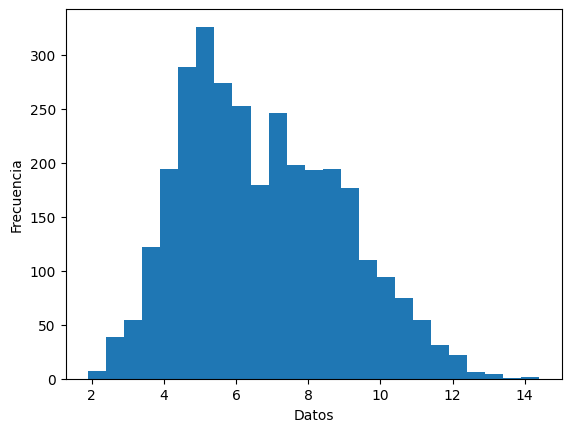

In [ ]:
plt.hist(df['data'],bins=25)
plt.xlabel("Datos")
plt.ylabel("Frecuencia")
plt.show()

Gráfico de los datos.

In [ ]:
print(pd.to_datetime(df["datetime"])[0].timestamp())
print(df["datetime"].apply(datetime.timestamp).astype("int64"))
print(type(df["datetime"].dt.date ))


1609459200.0
0       1609459200
1       1609459800
2       1609460400
3       1609461000
4       1609461600
           ...    
4459    1612134600
4460    1612135200
4461    1612135800
4462    1612136400
4463    1612137000
Name: datetime, Length: 4464, dtype: int64
<class 'pandas.core.series.Series'>


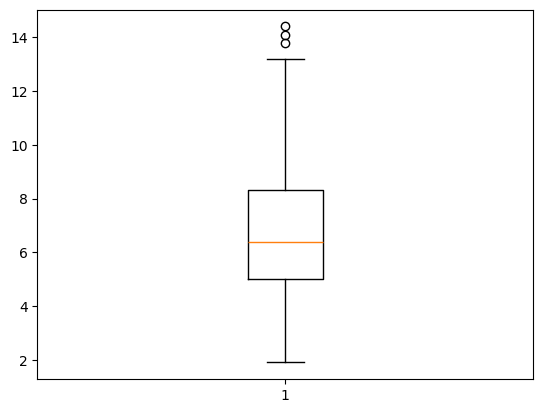

In [ ]:
data = df[df["data"].notna()]["data"]
plt.boxplot(data)
plt.show()

Generar una columna extra que tenga como dato la media de los 5 días pasados

In [ ]:
df_mlfv = df.copy()
df_real = pd.DataFrame()
#lo hice mal.
df_gb = df_mlfv.groupby(df_mlfv["datetime"].dt.date)["data"]
df_gb_sum = df_gb.sum().reset_index()
df_gb_count = df_gb.count().reset_index()

for i in range(4,31):
    df_real.loc[i,"mean_last_five_days"] = df_gb_sum.loc[i-4:i,"data"].sum() / df_gb_count.loc[i-4:i,"data"].sum() #CALCULO DE LA MEDIA
    df_real.loc[i,"datetime"] = df_gb_sum.loc[i,"datetime"]
df_real["datetime"] = pd.to_datetime(df_real["datetime"])
df_mlfv =pd.merge(df_mlfv,df_real,on="datetime",how="left")

#print(df_mlfv[df_mlfv["datetime"] == '2021-01-05'])
print(df_mlfv)

                datetime  data  mean_last_five_days
0    2021-01-01 00:00:00   7.3                  NaN
1    2021-01-01 00:10:00   7.5                  NaN
2    2021-01-01 00:20:00   NaN                  NaN
3    2021-01-01 00:30:00   NaN                  NaN
4    2021-01-01 00:40:00   NaN                  NaN
...                  ...   ...                  ...
4459 2021-01-31 23:10:00   5.8                  NaN
4460 2021-01-31 23:20:00   5.5                  NaN
4461 2021-01-31 23:30:00   5.2                  NaN
4462 2021-01-31 23:40:00   5.2                  NaN
4463 2021-01-31 23:50:00   5.2                  NaN

[4464 rows x 3 columns]


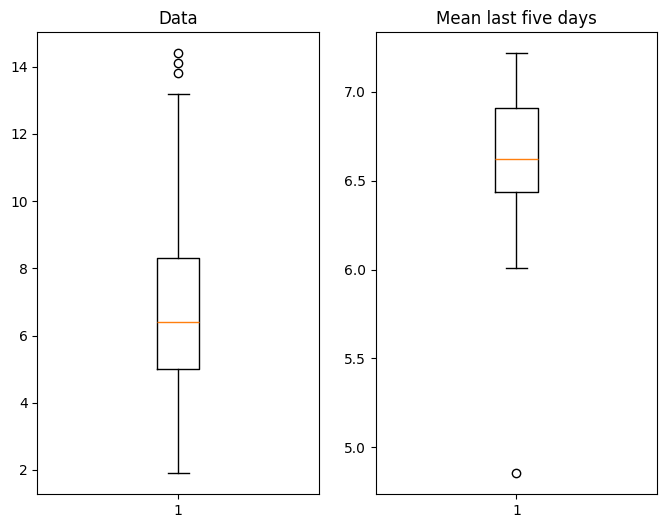

In [ ]:
X1 = df_mlfv[df_mlfv["data"].notna()]["data"]
X2 = df_mlfv[df_mlfv["mean_last_five_days"].notna()]["mean_last_five_days"]

fig,axes = plt.subplots(1,2,figsize=(8,6))
axes[0].boxplot(X1)
axes[0].set_title("Data")
axes[1].boxplot(X2)
axes[1].set_title("Mean last five days")
plt.show()

## Análisis de componentes principales. (PCA)

a) Crear un set de datos, gráficar y analizar.

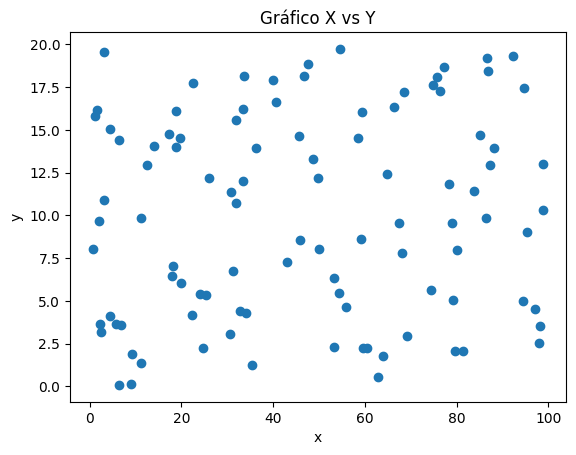

In [ ]:
rng = np.random.default_rng()

x = rng.uniform(0,100,100)
y = rng.uniform(0,20,100)

plt.scatter(x,y)
plt.title("Gráfico X vs Y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Cálculo del coeficiente de correlación de Pearson.

[[1.         0.10288914]
 [0.10288914 1.        ]]


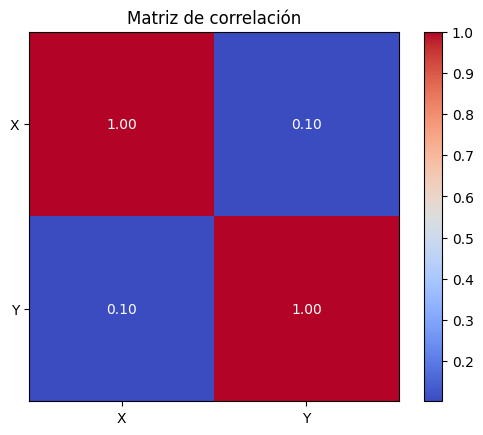

In [ ]:
X = pd.DataFrame({'X':x,'Y':y})

corr = np.corrcoef(X.T)
print(corr)

plt.imshow(corr,cmap='coolwarm')
plt.colorbar()
plt.title("Matriz de correlación")
plt.xticks([0,1],["X","Y"])
plt.yticks([0,1],["X","Y"])
for i in range(2):
  for j in range(2):
    plt.text(j,i,format(corr[i,j],".2f"),ha="center",va="center",color="w")

plt.show()

**¿Cuál es la diferencia entre varianza y desviación estándar?**

Tenemos tanto la varianza muestral como la poblacional. Utilizaremos la muestral.

Definición de varianza muestral:

$$
S_x^{2} = \frac {\sum_{i=1}^{n} (x_i-\bar{x})^{2}}{n-1}
$$


Definición de desviación estándar:

$$
S_x = \sqrt{S^{2}} = \sqrt{\frac {\sum_{i=1}^{n} (x_i-\bar{x})^{2}}{n-1}}
$$

Ambas medidas representan dispersión. La diferencia está en que la varianza lo representa en unidades al cuadrado (el motivo de esto se debe para que la suma no tenga terminos negativos que cancelen a otros), mientras que la desviación estándar lo hace en las unidades reales, por lo que es más interpretativa.

### Aplicación de PCA

### Q&A

#### ¿Por qué es importante estandarizar las variables antes de aplicar PCA?

Esto es debido a la naturaleza de las variables. Pueden estar medidas en escalas diferentes y sus valores numericos prevalecerian por encima de las demás.

Eso trae como consecuencia una dominación por parte de los grandes valores. (Modelos basados en distancias, lineales)

Al estandarizar, las variables se centran y escalan según su dispersión. (utilizando el Z-score scaling)

$$ s_{stand} = \frac{x - \bar{x}}{\sigma_x}$$

#### ¿Qué representa un valor propio grande en el contexto de PCA?

Representa la cantidad de información que puede capturar el vector propio generado por ese valor.

#### Explicar la relación entre autovectores y dirección de máxima varianza.

Los autovectores, mejor conocidos como vectores propios, son aquellos vectores particulares de un espacio vectorial que al aplicarle una transformación lineal, la deformación que sufren es solo de escalamiento. Es decir, solo se estiran o se encogen.

Están dados por la siguiente ecuación:

$$ Av = λv $$

donde $λ$ es un valor propio y $v$ es un autovector.

En este caso particular que estamos analizando, queremos reducir la dimensionalidad de nuestro conjunto de caracteristicas sin perder una cantidad significativa de información.

Para lograr esto, tomamos nuestra matriz de covarianza y con ella obtenemos los autovectores con sus respectivos valores propios.

Aquel vector propio cuyo eigenvalor es el mayor, tendrá la dirección de la máxima varianza.

(También estos vectores propios se pueden ver como los ejes donde se proyectan los datos)

#### Dado un conjunto de datos con “n” variables, ¿cuántos componentes principales como máximo puede tener PCA?

Puedo tener un máximo de n componentes principales.

#### ¿Qué dimensión tendrán los componentes principales?

Tendrán una dimensión menor a la anterior.

En nuestro caso como tenemos 2 caracteristicas, la estariamos reduciendo a 1.

#### Definir varianza explicada y la proporción de varianza explicada.

La varianza explicada es una parte de la varianza total que mis nuevas componentes pueden explicar.

$$Var_{explicada} = \frac{1}{\sum_{i=1}^{n}\lambda_{i}} v$$

Cada componente explica una cantidad especifica de la varianza total de los datos, por lo que la varianza explicada nos dice cuanto de la información original captura esa componente.



#### Cuáles y cuántos componentes principales seleccionaría para la obtención de la matriz proyección (nueva matriz de datos)? Mostrar la matriz proyección obtenida.

Lo contesto en la aplicación PCA

#### En un conjunto de dos variables altamente correlacionadas, ¿Esperaría que la primera componente principal explique la mayor parte de la varianza? Explicar.

Que sean altamente correlacionadas, implica que la covarianza o es positiva o negativa.
Por lo que una de las dos componentes podrían explicar la mayoria de esa varianza, pero no necesariamente la primera.

### Aplicación PCA

Estandarizamos los datos.

In [ ]:
medias = X.mean()
Xc = X - medias
X_stan = Xc / X.std()
print("Medias: ", medias.to_numpy())
#print("Datos centrados:\n", Xc.to_numpy())


Medias:  [46.74121784  9.98933354]


Cálculo de la matriz de covarianza

[[1.         0.10288914]
 [0.10288914 1.        ]]


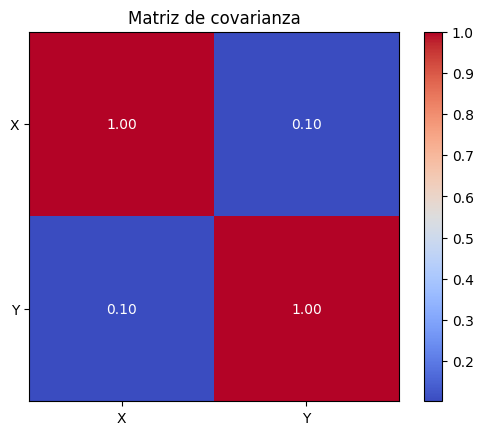

In [ ]:
cov = np.cov(X_stan,rowvar=False)
print(cov)

plt.imshow(cov,cmap='coolwarm')
plt.colorbar()
plt.title("Matriz de covarianza")
plt.xticks([0,1],["X","Y"])
plt.yticks([0,1],["X","Y"])
for i in range(2):
  for j in range(2):
    plt.text(j,i,format(cov[i,j],".2f"),ha="center",va="center",color="w")
plt.show()

Calculo del determinante y ceros de la ecuación caracteristica $λ^{2}-(a+d)λ+(ad-bc) = 0$

In [ ]:
a,b,c,d = cov.flatten()
coef = [1,-(a+d),a*d - b*c]
print("Coeficientes:",coef)

lambdas = np.roots(coef)
print("Valores propios: ", lambdas)


Coeficientes: [1, np.float64(-1.9999999999999993), np.float64(0.9894138242401223)]
Valores propios:  [1.10288914 0.89711086]


Obtención de los vectores propios.

In [ ]:
eigvals,eigvecs = np.linalg.eig(cov)
print("Valores propios: ",eigvals) #Otra manera de obtener los valores propios.
print("Vectores propios: ",eigvecs)

Valores propios:  [0.89711086 1.10288914]
Vectores propios:  [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]


Gráfica de los vectores propios y proyección de los datos.

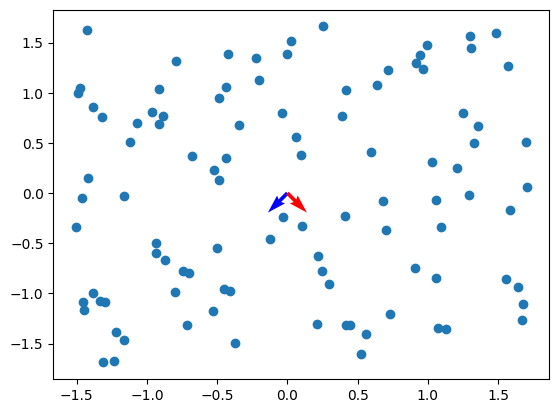

[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]


In [ ]:
plt.scatter(X_stan['X'],X_stan['Y'])
plt.quiver(0,0,
           eigvecs[0,0]/abs(eigvecs[0,0])*eigvals[0],
           eigvecs[0,1]/abs(eigvecs[0,1])*eigvals[0],
           color="blue")
plt.quiver(0,0,
           eigvecs[1,0]/abs(eigvecs[1,0])*eigvals[1],
           eigvecs[1,1]/abs(eigvecs[1,1])*eigvals[1],
           color="red")
plt.show()


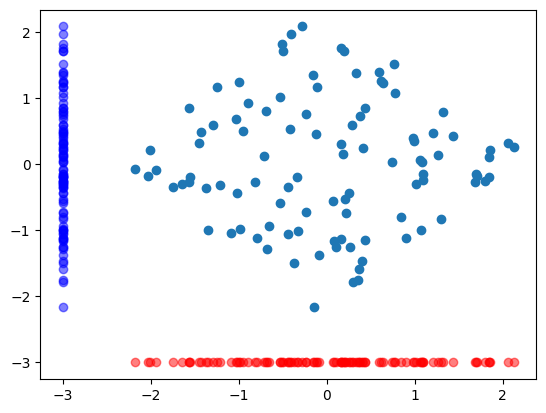

In [ ]:
datos_proyectados = X_stan @ eigvecs.T
datos_proyectados = datos_proyectados.rename(columns={0:"X",1:"Y"})
#print([-3]*len(datos_proyectados['X']))
#print(datos_proyectados)

plt.scatter(datos_proyectados["X"],datos_proyectados["Y"])
plt.scatter(datos_proyectados["X"],[-3]*len(datos_proyectados["X"]),
            color="red",alpha=0.5)
plt.scatter([-3]*len(datos_proyectados["Y"]),datos_proyectados["Y"],
            color="blue",alpha=0.5)
plt.show()

### Punto b.

In [ ]:
from sklearn.datasets import fetch_california_housing

data_house = fetch_california_housing()
print("Caracteristicas: ", data_house.feature_names)
print("Variable objetivo: ",data_house.target_names)

Caracteristicas:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Variable objetivo:  ['MedHouseVal']


Datos originales (SIN PCA)

In [ ]:
features = data_house.feature_names

X = pd.DataFrame(data_house.data,columns=features)
y = pd.DataFrame(data_house.target,columns=data_house.target_names)
print("Datos originales:\n",X.head())
print("Datos objetivo:\n",y.head())
print("Información de los datos:\n",X.info(),X.describe())


Datos originales:
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
Datos objetivo:
    MedHouseVal
0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms

Estandarizamos los datos y los spliteamos.
¿Estará bien esto?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

train_X,val_X,train_y,val_y = train_test_split(X_scaled,y_scaled)


Aplicar un modelo de regresión lineal y calculamos las metricas de desempeño del modelo.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
lin_reg = LinearRegression()
lin_reg.fit(train_X,train_y)
lin_reg_predictions = lin_reg.predict(val_X)
lin_reg_mae = mean_absolute_error(val_y,lin_reg_predictions)

print(f"Validación MAE para la regresión lineal: {lin_reg_mae}")

Validación MAE para la regresión lineal: 0.7905547384304148


Aplicación del PCA.

In [ ]:
from sklearn.decomposition import PCA
house_pca = PCA(n_components=8)
X_pca = house_pca.fit_transform(X_scaled)

varianza_acumulada = np.cumsum(house_pca.explained_variance_ratio_)
print("Varianza explicada por cada componente:", house_pca.explained_variance_ratio_)
print("varianza acumulada:",varianza_acumulada)

Varianza explicada por cada componente: [0.25336868 0.23516245 0.15888635 0.12887971 0.12538195 0.0824225
 0.01020022 0.00569814]
varianza acumulada: [0.25336868 0.48853113 0.64741747 0.77629718 0.90167913 0.98410164
 0.99430186 1.        ]


Como necesitamos el número minimo de componentes que expliquen al menos el 95% de la varianza, vamos a tomar 6 componentes.

In [ ]:
house_pca = PCA(n_components=6)
X_pca = house_pca.fit_transform(X_scaled)

print("Varianza explicada por cada componente:", house_pca.explained_variance_ratio_)
print("varianza acumulada:",varianza_acumulada)

Varianza explicada por cada componente: [0.25336868 0.23516245 0.15888635 0.12887971 0.12538195 0.0824225 ]
varianza acumulada: [0.25336868 0.48853113 0.64741747 0.77629718 0.90167913 0.98410164
 0.99430186 1.        ]


Gráfico Scree plot de la varianza explicada acumulada.

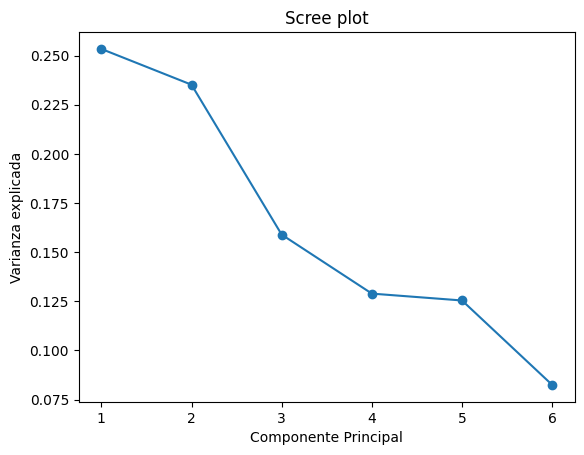

In [ ]:
pc_values = np.arange(house_pca.n_components_) + 1
plt.plot(pc_values,house_pca.explained_variance_ratio_,'o-')
plt.title("Scree plot")
plt.ylabel("Varianza explicada")
plt.xlabel("Componente Principal")
plt.show()

PROBAR EL MODELO CON LOS DATOS PROYECTADOS

In [ ]:
train_X_pca,val_X_pca,train_y,val_y = train_test_split(X_pca,y_scaled)

lin_reg_pca = LinearRegression()
lin_reg_pca.fit(train_X_pca,train_y)
lin_reg_pca_predictions = lin_reg_pca.predict(val_X_pca)
lin_reg_pca_mae = mean_absolute_error(val_y,lin_reg_pca_predictions)

print(f"Validación MAE para la regresión lineal: {lin_reg_pca_mae}")

Validación MAE para la regresión lineal: 0.5308300973030597


La reducción de la dimensionalidad provocó un descenso del MAE, por lo que nuestro modelo ha mejorado su desempeño.